# Задание 3: Эксперименты с регуляризацией

In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm



class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader 

In [4]:
import torch
import torch.nn as nn
import json

class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs

        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)

        self.layers = self._build_layers()

    def load_config(self, config_path):
        """
        Загружает конфигурацию из JSON файла
        """
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size

        layer_config = self.config.get('layers', [])

        for layer_spec in layer_config:
            layer_type = layer_spec['type']

            match layer_type:
                case 'linear':
                    out_size = layer_spec['size']
                    layers.append(nn.Linear(prev_size, out_size))
                    prev_size = out_size

                case 'relu':
                    layers.append(nn.ReLU())

                case 'sigmoid':
                    layers.append(nn.Sigmoid())

                case 'tanh':
                    layers.append(nn.Tanh())

                case 'dropout':
                    rate = layer_spec.get('rate', 0.5)
                    layers.append(nn.Dropout(rate))

                case 'batch_norm':
                    layers.append(nn.BatchNorm1d(prev_size))

                case 'layer_norm':
                    layers.append(nn.LayerNorm(prev_size))

                case _:
                    raise ValueError(f"Неизвестный тип слоя: {layer_type}")

        # Всегда добавляем финальный слой для классификации
        layers.append(nn.Linear(prev_size, self.num_classes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # "выпрямляем" картинку в вектор
        return self.layers(x)

In [5]:
def run_epoch(model, data_loader, criterion, optimizer = None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

# 3.1 Сравнение техник регуляризации

Единая архитектура

In [6]:
base_config = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        
        {"type": "linear", "size": 256},
        {"type": "relu"}
    ]
} 

Создаём конфиги с разными регуляризациями

In [11]:
configs = {
    "no_reg": {
        "config": {
            "input_size": 784,
            "num_classes": 10,
            "layers": [
                {"type": "linear", "size": 512},
                {"type": "relu"},
                {"type": "linear", "size": 256},
                {"type": "relu"}
            ]
        },
        "label": "Без регуляризации"
    },
    "dropout": {
        "config": {
            "input_size": 784,
            "num_classes": 10,
            "layers": [
                {"type": "linear", "size": 512},
                {"type": "relu"},
                {"type": "dropout", "rate": 0.4},
                {"type": "linear", "size": 256},
                {"type": "relu"},
                {"type": "dropout", "rate": 0.4}
            ]
        },
        "label": "Dropout"
    },
    "batch_norm": {
        "config": {
            "input_size": 784,
            "num_classes": 10,
            "layers": [
                {"type": "linear", "size": 512},
                {"type": "relu"},
                {"type": "batch_norm"},
                {"type": "linear", "size": 256},
                {"type": "relu"},
                {"type": "batch_norm"}
            ]
        },
        "label": "BatchNorm"
    },
    "both": {
        "config": {
            "input_size": 784,
            "num_classes": 10,
            "layers": [
                {"type": "linear", "size": 512},
                {"type": "relu"},
                {"type": "batch_norm"},
                {"type": "dropout", "rate": 0.4},
                {"type": "linear", "size": 256},
                {"type": "relu"},
                {"type": "batch_norm"},
                {"type": "dropout", "rate": 0.4}
            ]
        },
        "label": "Dropout + BatchNorm"
    },
    "l2": {
        "config": {
            "input_size": 784,
            "num_classes": 10,
            "layers": [
                {"type": "linear", "size": 512},
                {"type": "relu"},
                {"type": "linear", "size": 256},
                {"type": "relu"}
            ]
        },
        "label": "L2 Regularization",
        "use_l2": True
    }
}

Обучаем все модели

In [8]:
results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_mnist_loaders(batch_size=64)

for name, cfg in configs.items():
    print(f"\n=== Обучение: {cfg['regularization']} ===")
    
    model = FullyConnectedModel(config_path=None, **cfg["config"])
    model.to(device)
    
    # L2 regularization через weight decay
    if cfg.get("use_l2", False):
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = train_model(model, train_loader, test_loader, epochs=10, device=device)
    
    results.append({
        "name": name,
        "regularization": cfg["regularization"],
        "test_acc": history["test_accs"][-1],
    })
print(results)


=== Обучение: No Regularization ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.69it/s]


Epoch 1/10:
Train Loss: 0.2024, Train Acc: 0.9375
Test Loss: 0.1083, Test Acc: 0.9638
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.30it/s]


Epoch 2/10:
Train Loss: 0.0870, Train Acc: 0.9729
Test Loss: 0.0891, Test Acc: 0.9720
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.65it/s]


Epoch 3/10:
Train Loss: 0.0611, Train Acc: 0.9808
Test Loss: 0.0702, Test Acc: 0.9769
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.57it/s]


Epoch 4/10:
Train Loss: 0.0446, Train Acc: 0.9860
Test Loss: 0.0829, Test Acc: 0.9749
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.37it/s]


Epoch 5/10:
Train Loss: 0.0393, Train Acc: 0.9871
Test Loss: 0.0771, Test Acc: 0.9788
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.61it/s]


Epoch 6/10:
Train Loss: 0.0329, Train Acc: 0.9892
Test Loss: 0.0968, Test Acc: 0.9741
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.73it/s]


Epoch 7/10:
Train Loss: 0.0276, Train Acc: 0.9908
Test Loss: 0.1040, Test Acc: 0.9729
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.15it/s]


Epoch 8/10:
Train Loss: 0.0256, Train Acc: 0.9916
Test Loss: 0.0777, Test Acc: 0.9814
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.88it/s]


Epoch 9/10:
Train Loss: 0.0227, Train Acc: 0.9925
Test Loss: 0.0842, Test Acc: 0.9800
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.88it/s]


Epoch 10/10:
Train Loss: 0.0187, Train Acc: 0.9934
Test Loss: 0.1069, Test Acc: 0.9786
--------------------------------------------------

=== Обучение: Dropout (0.1) ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.69it/s]


Epoch 1/10:
Train Loss: 0.2068, Train Acc: 0.9361
Test Loss: 0.1158, Test Acc: 0.9654
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.98it/s]


Epoch 2/10:
Train Loss: 0.0866, Train Acc: 0.9731
Test Loss: 0.0869, Test Acc: 0.9714
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.33it/s]


Epoch 3/10:
Train Loss: 0.0631, Train Acc: 0.9802
Test Loss: 0.0748, Test Acc: 0.9777
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.11it/s]


Epoch 4/10:
Train Loss: 0.0485, Train Acc: 0.9846
Test Loss: 0.0794, Test Acc: 0.9768
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.94it/s]


Epoch 5/10:
Train Loss: 0.0406, Train Acc: 0.9870
Test Loss: 0.0761, Test Acc: 0.9789
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.11it/s]


Epoch 6/10:
Train Loss: 0.0360, Train Acc: 0.9882
Test Loss: 0.0829, Test Acc: 0.9788
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.76it/s]


Epoch 7/10:
Train Loss: 0.0259, Train Acc: 0.9922
Test Loss: 0.0921, Test Acc: 0.9770
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.00it/s]


Epoch 8/10:
Train Loss: 0.0266, Train Acc: 0.9915
Test Loss: 0.0768, Test Acc: 0.9798
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.45it/s]


Epoch 9/10:
Train Loss: 0.0233, Train Acc: 0.9926
Test Loss: 0.0746, Test Acc: 0.9820
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 39.04it/s]


Epoch 10/10:
Train Loss: 0.0210, Train Acc: 0.9931
Test Loss: 0.0892, Test Acc: 0.9797
--------------------------------------------------

=== Обучение: Dropout (0.3) ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.93it/s]


Epoch 1/10:
Train Loss: 0.2253, Train Acc: 0.9305
Test Loss: 0.1163, Test Acc: 0.9608
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.94it/s]


Epoch 2/10:
Train Loss: 0.0979, Train Acc: 0.9701
Test Loss: 0.1088, Test Acc: 0.9656
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.36it/s]


Epoch 3/10:
Train Loss: 0.0700, Train Acc: 0.9782
Test Loss: 0.0785, Test Acc: 0.9758
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.87it/s]


Epoch 4/10:
Train Loss: 0.0558, Train Acc: 0.9818
Test Loss: 0.0768, Test Acc: 0.9780
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.25it/s]


Epoch 5/10:
Train Loss: 0.0438, Train Acc: 0.9860
Test Loss: 0.0823, Test Acc: 0.9779
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.91it/s]


Epoch 6/10:
Train Loss: 0.0384, Train Acc: 0.9878
Test Loss: 0.0757, Test Acc: 0.9786
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.03it/s]


Epoch 7/10:
Train Loss: 0.0337, Train Acc: 0.9898
Test Loss: 0.0744, Test Acc: 0.9786
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.87it/s]


Epoch 8/10:
Train Loss: 0.0339, Train Acc: 0.9893
Test Loss: 0.0781, Test Acc: 0.9807
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.83it/s]


Epoch 9/10:
Train Loss: 0.0256, Train Acc: 0.9916
Test Loss: 0.0921, Test Acc: 0.9772
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.80it/s]


Epoch 10/10:
Train Loss: 0.0275, Train Acc: 0.9912
Test Loss: 0.0896, Test Acc: 0.9793
--------------------------------------------------

=== Обучение: Dropout (0.5) ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.59it/s]


Epoch 1/10:
Train Loss: 0.2433, Train Acc: 0.9264
Test Loss: 0.1176, Test Acc: 0.9632
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.88it/s]


Epoch 2/10:
Train Loss: 0.1085, Train Acc: 0.9680
Test Loss: 0.0817, Test Acc: 0.9733
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.60it/s]


Epoch 3/10:
Train Loss: 0.0785, Train Acc: 0.9764
Test Loss: 0.0761, Test Acc: 0.9749
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.99it/s]


Epoch 4/10:
Train Loss: 0.0637, Train Acc: 0.9808
Test Loss: 0.1020, Test Acc: 0.9700
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.58it/s]


Epoch 5/10:
Train Loss: 0.0560, Train Acc: 0.9820
Test Loss: 0.0967, Test Acc: 0.9745
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.31it/s]


Epoch 6/10:
Train Loss: 0.0421, Train Acc: 0.9870
Test Loss: 0.0866, Test Acc: 0.9778
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.03it/s]


Epoch 7/10:
Train Loss: 0.0439, Train Acc: 0.9861
Test Loss: 0.0805, Test Acc: 0.9792
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.46it/s]


Epoch 8/10:
Train Loss: 0.0348, Train Acc: 0.9891
Test Loss: 0.0872, Test Acc: 0.9796
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.76it/s]


Epoch 9/10:
Train Loss: 0.0350, Train Acc: 0.9891
Test Loss: 0.0834, Test Acc: 0.9813
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.56it/s]


Epoch 10/10:
Train Loss: 0.0279, Train Acc: 0.9914
Test Loss: 0.1229, Test Acc: 0.9766
--------------------------------------------------

=== Обучение: BatchNorm ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.55it/s]


Epoch 1/10:
Train Loss: 0.1887, Train Acc: 0.9434
Test Loss: 0.1083, Test Acc: 0.9647
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.55it/s]


Epoch 2/10:
Train Loss: 0.0856, Train Acc: 0.9740
Test Loss: 0.0903, Test Acc: 0.9726
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.48it/s]


Epoch 3/10:
Train Loss: 0.0626, Train Acc: 0.9804
Test Loss: 0.0688, Test Acc: 0.9792
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.40it/s]


Epoch 4/10:
Train Loss: 0.0478, Train Acc: 0.9851
Test Loss: 0.0617, Test Acc: 0.9807
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.73it/s]


Epoch 5/10:
Train Loss: 0.0393, Train Acc: 0.9874
Test Loss: 0.0636, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.71it/s]


Epoch 6/10:
Train Loss: 0.0318, Train Acc: 0.9891
Test Loss: 0.0674, Test Acc: 0.9812
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 39.02it/s]


Epoch 7/10:
Train Loss: 0.0284, Train Acc: 0.9911
Test Loss: 0.0652, Test Acc: 0.9822
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.87it/s]


Epoch 8/10:
Train Loss: 0.0251, Train Acc: 0.9917
Test Loss: 0.0689, Test Acc: 0.9801
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.69it/s]


Epoch 9/10:
Train Loss: 0.0218, Train Acc: 0.9925
Test Loss: 0.0655, Test Acc: 0.9814
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.69it/s]


Epoch 10/10:
Train Loss: 0.0186, Train Acc: 0.9935
Test Loss: 0.0710, Test Acc: 0.9809
--------------------------------------------------

=== Обучение: Dropout + BatchNorm ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.64it/s]


Epoch 1/10:
Train Loss: 0.2175, Train Acc: 0.9355
Test Loss: 0.1156, Test Acc: 0.9608
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.68it/s]


Epoch 2/10:
Train Loss: 0.0990, Train Acc: 0.9704
Test Loss: 0.0787, Test Acc: 0.9745
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 26.16it/s]


Epoch 3/10:
Train Loss: 0.0747, Train Acc: 0.9772
Test Loss: 0.0732, Test Acc: 0.9770
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.98it/s]


Epoch 4/10:
Train Loss: 0.0593, Train Acc: 0.9809
Test Loss: 0.0901, Test Acc: 0.9725
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.90it/s]


Epoch 5/10:
Train Loss: 0.0506, Train Acc: 0.9839
Test Loss: 0.0766, Test Acc: 0.9770
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.69it/s]


Epoch 6/10:
Train Loss: 0.0423, Train Acc: 0.9859
Test Loss: 0.0886, Test Acc: 0.9740
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.72it/s]


Epoch 7/10:
Train Loss: 0.0348, Train Acc: 0.9883
Test Loss: 0.0700, Test Acc: 0.9800
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.64it/s]


Epoch 8/10:
Train Loss: 0.0313, Train Acc: 0.9900
Test Loss: 0.0788, Test Acc: 0.9788
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.69it/s]


Epoch 9/10:
Train Loss: 0.0294, Train Acc: 0.9904
Test Loss: 0.0835, Test Acc: 0.9779
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.50it/s]


Epoch 10/10:
Train Loss: 0.0242, Train Acc: 0.9923
Test Loss: 0.0792, Test Acc: 0.9797
--------------------------------------------------

=== Обучение: L2 (weight decay) ===


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.03it/s]


Epoch 1/10:
Train Loss: 0.2047, Train Acc: 0.9381
Test Loss: 0.1100, Test Acc: 0.9643
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.42it/s]


Epoch 2/10:
Train Loss: 0.0839, Train Acc: 0.9741
Test Loss: 0.0690, Test Acc: 0.9787
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.13it/s]


Epoch 3/10:
Train Loss: 0.0608, Train Acc: 0.9805
Test Loss: 0.0822, Test Acc: 0.9749
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.82it/s]


Epoch 4/10:
Train Loss: 0.0466, Train Acc: 0.9849
Test Loss: 0.0803, Test Acc: 0.9776
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 39.19it/s]


Epoch 5/10:
Train Loss: 0.0375, Train Acc: 0.9879
Test Loss: 0.0819, Test Acc: 0.9775
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.37it/s]


Epoch 6/10:
Train Loss: 0.0316, Train Acc: 0.9898
Test Loss: 0.0947, Test Acc: 0.9753
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.36it/s]


Epoch 7/10:
Train Loss: 0.0292, Train Acc: 0.9903
Test Loss: 0.0749, Test Acc: 0.9805
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.24it/s]


Epoch 8/10:
Train Loss: 0.0249, Train Acc: 0.9921
Test Loss: 0.0859, Test Acc: 0.9792
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.87it/s]


Epoch 9/10:
Train Loss: 0.0215, Train Acc: 0.9937
Test Loss: 0.0862, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.77it/s]

Epoch 10/10:
Train Loss: 0.0205, Train Acc: 0.9933
Test Loss: 0.1035, Test Acc: 0.9761
--------------------------------------------------
[{'name': 'no_regularization', 'regularization': 'No Regularization', 'test_acc': 0.9786}, {'name': 'dropout_0_1', 'regularization': 'Dropout (0.1)', 'test_acc': 0.9797}, {'name': 'dropout_0_3', 'regularization': 'Dropout (0.3)', 'test_acc': 0.9793}, {'name': 'dropout_0_5', 'regularization': 'Dropout (0.5)', 'test_acc': 0.9766}, {'name': 'batch_norm', 'regularization': 'BatchNorm', 'test_acc': 0.9809}, {'name': 'dropout_batch_norm', 'regularization': 'Dropout + BatchNorm', 'test_acc': 0.9797}, {'name': 'l2_regularization', 'regularization': 'L2 (weight decay)', 'test_acc': 0.9761}]


Визуализируем результаты

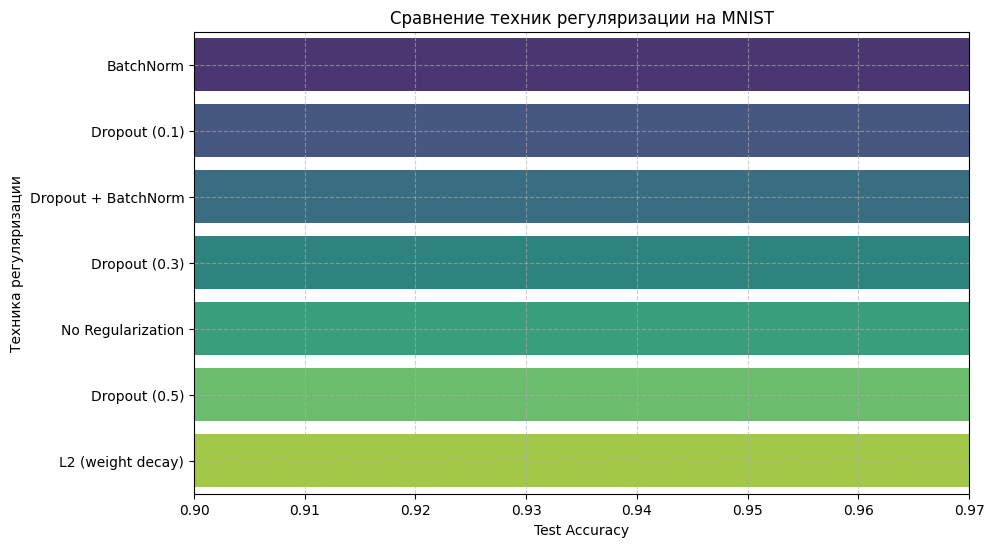

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)
df_results.sort_values(by="test_acc", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="test_acc", y="regularization", palette="viridis")
plt.title("Сравнение техник регуляризации на MNIST")
plt.xlabel("Test Accuracy")
plt.ylabel("Техника регуляризации")
plt.xlim(0.9, 0.97)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Распределение весов

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


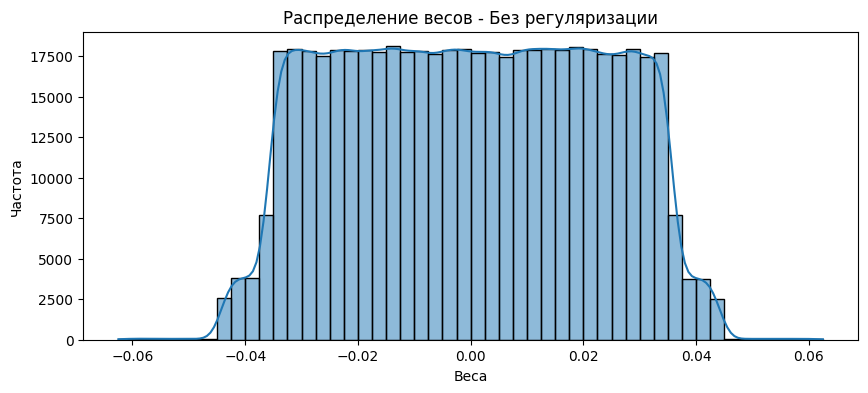

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


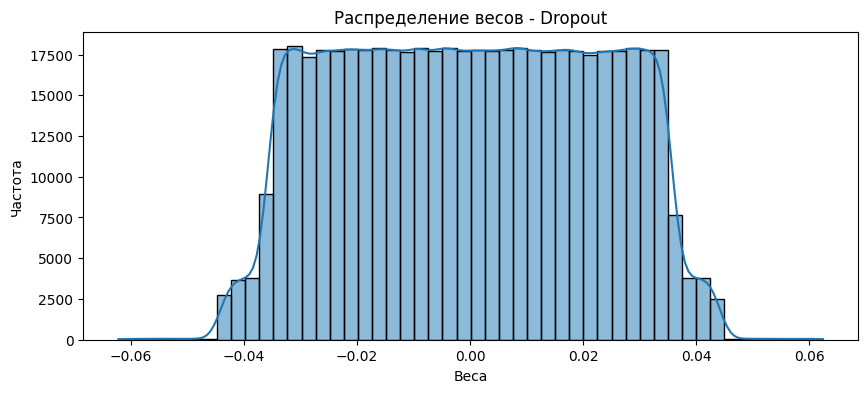

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


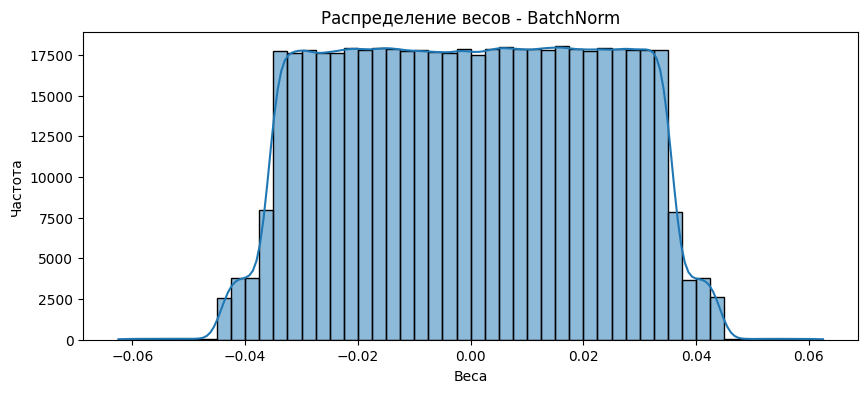

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


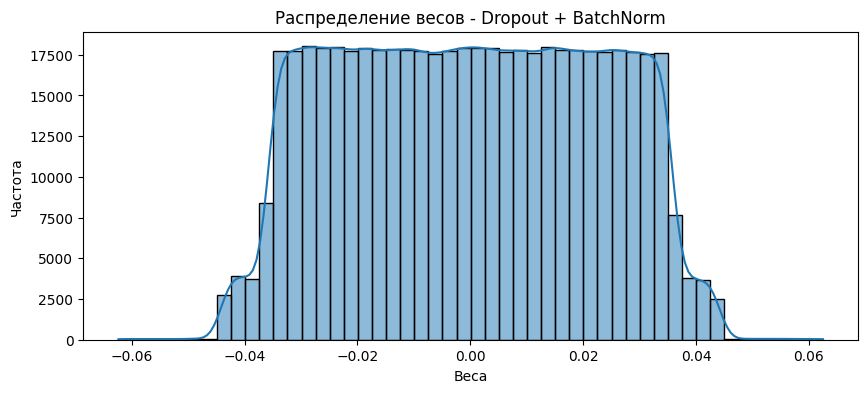

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


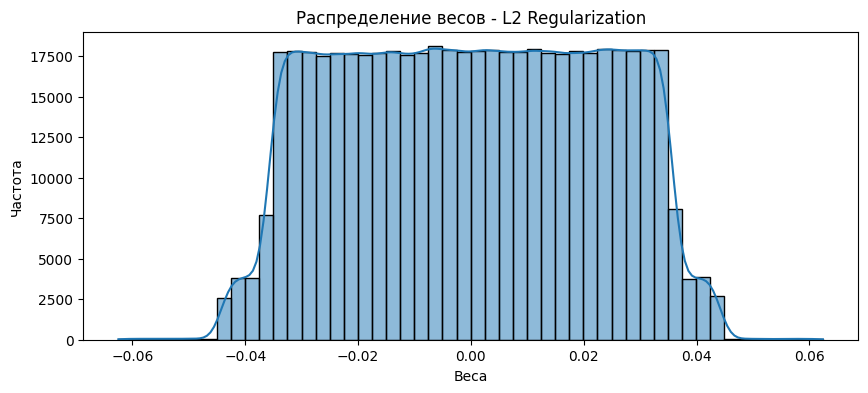

In [12]:
models = {}

for key, cfg in configs.items():
    model = FullyConnectedModel(config_path=None, **cfg["config"])
    models[key] = model
    
def plot_weight_distribution(model, title):
    plt.figure(figsize=(10, 4))
    weights = []
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            weights.extend(layer.weight.data.cpu().numpy().flatten())
    
    sns.histplot(weights, bins=50, kde=True)
    plt.title(title)
    plt.xlabel("Веса")
    plt.ylabel("Частота")
    plt.show()
    
plot_weight_distribution(models["no_reg"], "Распределение весов - Без регуляризации")
plot_weight_distribution(models["dropout"], "Распределение весов - Dropout")
plot_weight_distribution(models["batch_norm"], "Распределение весов - BatchNorm")
plot_weight_distribution(models["both"], "Распределение весов - Dropout + BatchNorm")
plot_weight_distribution(models["l2"], "Распределение весов - L2 Regularization")

# 3.2 Адаптивная регуляризация 

Добавляем адаптивный dropout

In [13]:
def adaptive_dropout_rate(epoch, max_epochs=10):
    return min(0.5, 0.1 + 0.4 * (epoch / max_epochs))

adaptive_dropout_config = {
    "input_size": 784,
    "num_classes": 10,
    "layers": base_config["layers"] + [
        {"type": "dropout", "rate": 0.4}
    ]
}

Обучение с изменяющимся dropout

In [15]:
model_adaptive = FullyConnectedModel(config_path=None, **adaptive_dropout_config)
optimizer = optim.Adam(model_adaptive.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
adaptive_history = []

for epoch in range(10):
    rate = adaptive_dropout_rate(epoch)
    model_adaptive.layers[-1] = nn.Dropout(rate)
    
    train_loss, train_acc = run_epoch(model_adaptive, train_loader, criterion, optimizer, device)
    test_loss, test_acc = run_epoch(model_adaptive, test_loader, criterion, None, device, is_test=True)
    
    adaptive_history.append({
        'epoch': epoch+1,
        'dropout_rate': rate,
        'train_acc': train_acc,
        'test_acc': test_acc
    })

print(pd.DataFrame(adaptive_history))

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 26.05it/s]

   epoch  dropout_rate  train_acc  test_acc
0      1          0.10   0.509950    0.9595
1      2          0.14   0.539617    0.9722
2      3          0.18   0.528117    0.9744
3      4          0.22   0.507217    0.9741
4      5          0.26   0.489350    0.9754
5      6          0.30   0.466383    0.9761
6      7          0.34   0.450017    0.9702
7      8          0.38   0.430667    0.9723
8      9          0.42   0.406050    0.9743
9     10          0.46   0.387867    0.9762


Разные значения momentum в BatchNorm

In [16]:
momentum_values = [0.1, 0.5, 0.9]

for m in momentum_values:
    config = {
        "input_size": 784,
        "num_classes": 10,
        "layers": base_config["layers"] + [
            {"type": "batch_norm", "momentum": m}
        ]
    }
    model = FullyConnectedModel(**config).to(device)
    history = train_model(model, train_loader, test_loader, epochs=10, device=device)
    
    print(f"Momentum {m}: Final Test Acc = {history['test_accs'][-1]:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.14it/s]


Epoch 1/10:
Train Loss: 0.1888, Train Acc: 0.9443
Test Loss: 0.1121, Test Acc: 0.9625
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.41it/s]


Epoch 2/10:
Train Loss: 0.0848, Train Acc: 0.9731
Test Loss: 0.0778, Test Acc: 0.9754
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.44it/s]


Epoch 3/10:
Train Loss: 0.0619, Train Acc: 0.9805
Test Loss: 0.0764, Test Acc: 0.9761
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.98it/s]


Epoch 4/10:
Train Loss: 0.0472, Train Acc: 0.9844
Test Loss: 0.0716, Test Acc: 0.9788
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.83it/s]


Epoch 5/10:
Train Loss: 0.0397, Train Acc: 0.9871
Test Loss: 0.0638, Test Acc: 0.9803
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.71it/s]


Epoch 6/10:
Train Loss: 0.0318, Train Acc: 0.9894
Test Loss: 0.0802, Test Acc: 0.9775
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.92it/s]


Epoch 7/10:
Train Loss: 0.0292, Train Acc: 0.9902
Test Loss: 0.0744, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.32it/s]


Epoch 8/10:
Train Loss: 0.0254, Train Acc: 0.9915
Test Loss: 0.0748, Test Acc: 0.9792
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.51it/s]


Epoch 9/10:
Train Loss: 0.0192, Train Acc: 0.9935
Test Loss: 0.0660, Test Acc: 0.9823
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.19it/s]


Epoch 10/10:
Train Loss: 0.0201, Train Acc: 0.9935
Test Loss: 0.0633, Test Acc: 0.9836
--------------------------------------------------
Momentum 0.1: Final Test Acc = 0.9836


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.61it/s]


Epoch 1/10:
Train Loss: 0.1875, Train Acc: 0.9446
Test Loss: 0.1089, Test Acc: 0.9641
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.11it/s]


Epoch 2/10:
Train Loss: 0.0884, Train Acc: 0.9730
Test Loss: 0.0780, Test Acc: 0.9751
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.99it/s]


Epoch 3/10:
Train Loss: 0.0617, Train Acc: 0.9801
Test Loss: 0.0772, Test Acc: 0.9755
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.80it/s]


Epoch 4/10:
Train Loss: 0.0513, Train Acc: 0.9836
Test Loss: 0.0751, Test Acc: 0.9760
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.00it/s]


Epoch 5/10:
Train Loss: 0.0391, Train Acc: 0.9873
Test Loss: 0.0903, Test Acc: 0.9720
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.06it/s]


Epoch 6/10:
Train Loss: 0.0334, Train Acc: 0.9889
Test Loss: 0.0766, Test Acc: 0.9787
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.77it/s]


Epoch 7/10:
Train Loss: 0.0280, Train Acc: 0.9905
Test Loss: 0.0676, Test Acc: 0.9801
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.19it/s]


Epoch 8/10:
Train Loss: 0.0233, Train Acc: 0.9921
Test Loss: 0.0724, Test Acc: 0.9804
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.42it/s]


Epoch 9/10:
Train Loss: 0.0215, Train Acc: 0.9926
Test Loss: 0.0735, Test Acc: 0.9803
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.88it/s]


Epoch 10/10:
Train Loss: 0.0179, Train Acc: 0.9940
Test Loss: 0.0837, Test Acc: 0.9797
--------------------------------------------------
Momentum 0.5: Final Test Acc = 0.9797


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.56it/s]


Epoch 1/10:
Train Loss: 0.1915, Train Acc: 0.9425
Test Loss: 0.0943, Test Acc: 0.9691
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.68it/s]


Epoch 2/10:
Train Loss: 0.0862, Train Acc: 0.9737
Test Loss: 0.0771, Test Acc: 0.9763
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.33it/s]


Epoch 3/10:
Train Loss: 0.0609, Train Acc: 0.9801
Test Loss: 0.0698, Test Acc: 0.9786
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.40it/s]


Epoch 4/10:
Train Loss: 0.0490, Train Acc: 0.9840
Test Loss: 0.0779, Test Acc: 0.9761
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.92it/s]


Epoch 5/10:
Train Loss: 0.0389, Train Acc: 0.9871
Test Loss: 0.0671, Test Acc: 0.9785
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.13it/s]


Epoch 6/10:
Train Loss: 0.0332, Train Acc: 0.9895
Test Loss: 0.0640, Test Acc: 0.9809
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.54it/s]


Epoch 7/10:
Train Loss: 0.0252, Train Acc: 0.9917
Test Loss: 0.0750, Test Acc: 0.9762
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.90it/s]


Epoch 8/10:
Train Loss: 0.0255, Train Acc: 0.9916
Test Loss: 0.0684, Test Acc: 0.9805
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.99it/s]


Epoch 9/10:
Train Loss: 0.0236, Train Acc: 0.9923
Test Loss: 0.0727, Test Acc: 0.9812
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.65it/s]

Epoch 10/10:
Train Loss: 0.0206, Train Acc: 0.9929
Test Loss: 0.0635, Test Acc: 0.9825
--------------------------------------------------
Momentum 0.9: Final Test Acc = 0.9825


Комбинирование регуляризаций

In [17]:
combined_config = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},
        {"type": "dropout", "rate": 0.3},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "batch_norm"},
        {"type": "dropout", "rate": 0.5}
    ]
}

model_combined = FullyConnectedModel(**combined_config).to(device)
history = train_model(model_combined, train_loader, test_loader, epochs=10, device=device)
print(f"Combined reg: Test Acc = {history['test_accs'][-1]:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.21it/s]


Epoch 1/10:
Train Loss: 0.2683, Train Acc: 0.9196
Test Loss: 0.1224, Test Acc: 0.9635
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.78it/s]


Epoch 2/10:
Train Loss: 0.1606, Train Acc: 0.9506
Test Loss: 0.0946, Test Acc: 0.9693
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.08it/s]


Epoch 3/10:
Train Loss: 0.1360, Train Acc: 0.9583
Test Loss: 0.0830, Test Acc: 0.9748
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.50it/s]


Epoch 4/10:
Train Loss: 0.1259, Train Acc: 0.9603
Test Loss: 0.0795, Test Acc: 0.9750
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.49it/s]


Epoch 5/10:
Train Loss: 0.1120, Train Acc: 0.9647
Test Loss: 0.0721, Test Acc: 0.9768
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.62it/s]


Epoch 6/10:
Train Loss: 0.1033, Train Acc: 0.9679
Test Loss: 0.0721, Test Acc: 0.9781
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.15it/s]


Epoch 7/10:
Train Loss: 0.0952, Train Acc: 0.9703
Test Loss: 0.0864, Test Acc: 0.9773
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.56it/s]


Epoch 8/10:
Train Loss: 0.0961, Train Acc: 0.9696
Test Loss: 0.0710, Test Acc: 0.9780
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.52it/s]


Epoch 9/10:
Train Loss: 0.0914, Train Acc: 0.9710
Test Loss: 0.0882, Test Acc: 0.9795
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.19it/s]

Epoch 10/10:
Train Loss: 0.0825, Train Acc: 0.9740
Test Loss: 0.0808, Test Acc: 0.9803
--------------------------------------------------
Combined reg: Test Acc = 0.9803


# Комментарии

Я надеюсь то, что я 1 и 2 пункты ДЗ прокомментировал крайне подробно, вы простите меня за то, что в 3-ем пункте я почти комментарии не писал. Несмотря на то, что я это ДЗ выполняю где-то 6 часов, мне очень все понравилось, интересно. Спасибо за просмотр моей ДЗ (^_^) 